# Reinforcement Learning Group Project

Author: Kim Isabella Zierahn, 6635183


This notebook documents my contributions and code to the group project. It contains checkpoints, thoughts, code snippets, where I tried out things, and plots.


## Checkpoint 1: Get your algorithms up and running

I am comparing three PPO models that get increasingly optimized. The performance is tested on simple environments to determine the best working algorithm out of the three. For continous actions, I am using the Pendulum and HalfCheetah from the OpenAI Gym.

I am comparing five PPO models that get increasingly optimized:

| Model       | Training phases   | Surrogate objective                                                              | Policy parameterization |
|-------------|-------------------|----------------------------------------------------------------------------------|------------------------|
| Vanilla PPO | Policy phase only | Clipped surrogate objective                                                      | Normal distribution|
| PPG         | Policy phase + auxiliary phase | Clipped surrogate objective + behavioral cloning loss + arbitrary auxiliary loss | Normal distribution|
| PPG KL      | Policy phase + auxiliary phase | Reversed KL divergence + behavioral cloning loss + arbitrary auxiliary loss | Normal distribution|
| PPG Beta    | Policy phase + auxiliary phase | Clipped surrogate objective + behavioral cloning loss + arbitrary auxiliary loss | Beta distribution|
| PPG KL Beta | Policy phase + auxiliary phase | Reversed KL divergence + behavioral cloning loss + arbitrary auxiliary loss | Beta distribution|


#### Vanilla PPO

This is the standard unmodified **vanilla PPO** algorithm that I take as a base comparison.

**Source:** The basis of this PPO base algorithm comes from: University of Tübingen, Autonomous Learning, Reinforcement Learning Lecture 8: "PPO_08_solution.py"

#### PPG

This is a **PPG** algorithm, a modified version of PPO. It consists of two training phases: a policy phase and an additional **periodic auxiliary phase**. During the policy phase, we are training the agent with vanilla PPO, optimizing the clipped surrogate objective. During the auxiliary phase, we distill features from the value function into the policy network

#### PPG with KL divergence

This is a PPG algorithm using a **reversed KL divergence** for regularization instead of a clipped objective. It uses a soft constraint on the reversed KL distance between
the initial and the updated policy.

#### PPG with Beta distribution

This is a PPG algorithm with a **Beta distribution** for policy parameterization instead of a Normal distribution. It is an optimized version of PPG, where we are using a Beta distribution for the action space and initializing the weights of the policy network with the weights of the value network.

#### PPG with KL divergence and Beta distribution

This is a PPG algorithm using a **reversed KL divergence** for the loss and a **Beta distribution** for policy parameterization.

In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env
from hockey.hockey_env import Mode
from sympy.printing.pretty.pretty_symbology import line_width
from tueplots import bundles

### GymEnv: Pendulum

In [3]:
env_pend = gym.make("Pendulum-v1")
state_dim = env_pend.observation_space.shape[0]
action_dim = env_pend.action_space.shape[0]

#### Comparison of Training Behavior

All five models were trained in the **Pendulum** environment for 5000 episodes on the cluster. In the following, I am comparing the training behavior of the five models.

In [63]:
# Load rewards
rewards_ppo_pendulum = np.load("../dat/pendulum/rewards_ppo_pendulum.npy")
rewards_ppg_pendulum = np.load("../dat/pendulum/rewards_ppg_pendulum.npy")
rewards_ppg_kl_pendulum = np.load("../dat/pendulum/rewards_ppg_kl_pendulum.npy")
# rewards_ppg_beta_pendulum = np.load("../dat/pendulum/rewards_ppg_beta_pendulum.npy")
# rewards_ppg_kl_beta_pendulum = np.load("../dat/pendulum/rewards_ppg_kl_beta_pendulum.npy")

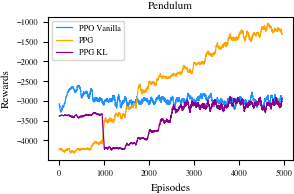

In [65]:
# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 50

plt.rcParams.update(bundles.icml2022(column = "full", nrows = 1, ncols = 1, usetex = False))
fig, ax = plt.subplots(figsize = (3, 2))
plt.plot(moving_average(rewards_ppo_pendulum, wind_size), label = "PPO Vanilla", linewidth = 0.9, color = "dodgerblue")
plt.plot(moving_average(rewards_ppg_pendulum, wind_size), label = "PPG", linewidth = 0.9, color = "orange")
plt.plot(moving_average(rewards_ppg_kl_pendulum, wind_size), label = "PPG KL", linewidth = 0.9, color = "darkmagenta")
# plt.plot(moving_average(rewards_ppg_beta_pendulum, wind_size), label = "PPG Beta", linewidth = 0.9, color = "forestgreen")
# plt.plot(moving_average(rewards_ppg_kl_beta_pendulum, wind_size), label = "PPG KL Beta", linewidth = 0.9, color = "crimson")
plt.legend()
plt.title("Pendulum")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

# save figure as png
fig.savefig("../doc/fig/comparison_pendulum.png", dpi = 1000, bbox_inches = "tight", pad_inches = 0.1, transparent = True)

### GymEnv: HalfCheetah

In [3]:
env_cheetah = gym.make("HalfCheetah-v5")
state_dim = env_cheetah.observation_space.shape[0]
action_dim = env_cheetah.action_space.shape[0]

#### Comparison of Training Behavior

All five models were trained in the **HalfCheetah** environment for 5000 episodes on the cluster. In the following, I am comparing the training behavior of the five models.

In [5]:
# Load rewards
rewards_ppo_cheetah = np.load("../dat/cheetah/rewards_ppo_halfcheetah.npy")
rewards_ppg_cheetah = np.load("../dat/cheetah/rewards_ppg_halfcheetah.npy")
rewards_ppg_kl_cheetah = np.load("../dat/cheetah/rewards_ppg_kl_halfcheetah.npy")
rewards_ppg_beta_cheetah = np.load("../dat/cheetah/rewards_ppg_beta_halfcheetah.npy")
rewards_ppg_kl_beta_cheetah = np.load("../dat/cheetah/rewards_ppg_kl_beta_halfcheetah.npy")

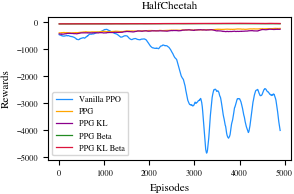

In [24]:
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 100

plt.rcParams.update(bundles.icml2022(column = "full", nrows = 1, ncols = 1, usetex = False))
fig, ax = plt.subplots(figsize = (3, 2))
plt.plot(moving_average(rewards_ppo_cheetah, wind_size), label = "Vanilla PPO", linewidth = 0.9, color = "dodgerblue")
plt.plot(moving_average(rewards_ppg_cheetah, wind_size), label = "PPG", linewidth = 0.9, color = "orange")
plt.plot(moving_average(rewards_ppg_kl_cheetah, wind_size), label = "PPG KL", linewidth = 0.9, color = "darkmagenta")
plt.plot(moving_average(rewards_ppg_beta_cheetah, wind_size), label = "PPG Beta", linewidth = 0.9, color = "forestgreen")
plt.plot(moving_average(rewards_ppg_kl_beta_cheetah, wind_size), label = "PPG KL Beta", linewidth = 0.9, color = "crimson")
plt.legend()
plt.title("HalfCheetah")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

# save figure as png
fig.savefig("../doc/fig/comparison_cheetah_wppo.png", dpi = 1000, bbox_inches = "tight", pad_inches = 0.1, transparent = True)

Based on these performances, we choose the **PPG with KL divergence** algorithm for the hockey environment as the final model.

## Checkpoint 2: Hockey – learning to handle the puck

In this part, before training my final agent on the cluster, I am trying to see a sensible training behavior, i.e. the reward should increase over time and I am checking the proportion of games I won. I am using the basic opponent for this purpose.

In [35]:
env_hockey = h_env.HockeyEnv_BasicOpponent(mode = Mode.NORMAL, weak_opponent = False)
state_dim = env_hockey.observation_space.shape[0]
action_dim = env_hockey.action_space.shape[0]

In [36]:
# Load rewards
rewards_ppo_hockey = np.load("../dat/hockey/rewards_ppo.npy")
rewards_ppg_hockey = np.load("../dat/hockey/rewards_ppg_gae.npy")
rewards_ppg_kl_hockey = np.load("../dat/hockey/rewards_ppg_kl.npy")
rewards_ppg_beta_hockey = np.load("../dat/hockey/rewards_ppg_beta.npy")
rewards_ppg_kl_beta_hockey = np.load("../dat/hockey/rewards_ppg_kl_beta.npy")

In [37]:
# Load information about winner
info_ppo_hockey = np.load("../dat/hockey/info_ppo.npy")
info_ppg_hockey = np.load("../dat/hockey/info_ppg_gae.npy")
info_ppg_kl_hockey = np.load("../dat/hockey/info_ppg_kl.npy")
info_ppg_beta_hockey = np.load("../dat/hockey/info_ppg_beta.npy")
info_ppg_kl_beta_hockey = np.load("../dat/hockey/info_ppg_kl_beta.npy")

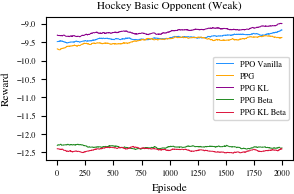

In [56]:
# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 800

plt.rcParams.update(bundles.icml2022(column = "full", nrows = 1, ncols = 1, usetex = False))
fig, ax = plt.subplots(figsize = (3, 2))
plt.plot(moving_average(rewards_ppo_hockey, wind_size), label = "PPO Vanilla", linewidth = 0.7, color = "dodgerblue")
plt.plot(moving_average(rewards_ppg_hockey, wind_size), label = "PPG", linewidth = 0.7, color = "orange")
plt.plot(moving_average(rewards_ppg_kl_hockey, wind_size), label = "PPG KL", linewidth = 0.7, color = "darkmagenta")
plt.plot(moving_average(rewards_ppg_beta_hockey, wind_size), label = "PPG Beta", linewidth = 0.7, color = "forestgreen")
plt.plot(moving_average(rewards_ppg_kl_beta_hockey, wind_size), label = "PPG KL Beta", linewidth = 0.7, color = "crimson")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Hockey Basic Opponent (Weak)")
plt.legend()
# plt.grid()
plt.show()

# save figure as png
fig.savefig("../doc/fig/hockey_env_training.png", dpi = 1000, bbox_inches = "tight", pad_inches = 0.1, transparent = True)

In [39]:
# calc average reward
def average_reward(rewards):
    return np.round(np.mean(rewards))

print("PPO Vanilla: ", average_reward(rewards_ppo_hockey))
print("PPG: ", average_reward(rewards_ppg_hockey))
print("PPG KL: ", average_reward(rewards_ppg_kl_hockey))
print("PPG Beta: ", average_reward(rewards_ppg_beta_hockey))
print("PPG KL Beta: ", average_reward(rewards_ppg_kl_beta_hockey))

PPO Vanilla:  -9.0
PPG:  -9.0
PPG KL:  -9.0
PPG Beta:  -12.0
PPG KL Beta:  -12.0


Win rate PPO: 0.114, 
Win rate PPG: 0.123, 
Win rate PPG KL: 0.081, 
Win rate PPG Beta: 0.049, 
Win rate PPG KL Beta: 0.052


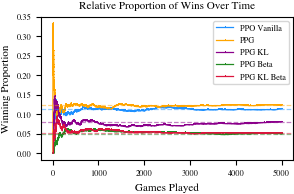

In [51]:
# Plot win rate for every agent
# calculate the number of 0,-1, 1 for each episode and divide by the number of episodes
num_episodes = len(info_ppo_hockey)

num_wins_ppo = np.sum(np.array(info_ppo_hockey) == 1)
num_wins_ppg_gae = np.sum(np.array(info_ppg_hockey) == 1)
num_wins_ppg_kl = np.sum(np.array(info_ppg_kl_hockey) == 1)
num_wins_ppg_beta = np.sum(np.array(info_ppg_beta_hockey) == 1)
num_wins_ppg_kl_beta = np.sum(np.array(info_ppg_kl_beta_hockey) == 1)

ratio_wins_ppo = round(num_wins_ppo / num_episodes, 3)
ratio_wins_ppg = round(num_wins_ppg_gae / num_episodes, 3)
ratio_wins_ppg_kl = round(num_wins_ppg_kl / num_episodes, 3)
ratio_wins_ppg_beta = round(num_wins_ppg_beta / num_episodes, 3)
ratio_wins_ppg_kl_beta = round(num_wins_ppg_kl_beta / num_episodes, 3)

print(f"Win rate PPO: {ratio_wins_ppo}, \nWin rate PPG: {ratio_wins_ppg}, \nWin rate PPG KL: {ratio_wins_ppg_kl}, \nWin rate PPG Beta: {ratio_wins_ppg_beta}, \nWin rate PPG KL Beta: {ratio_wins_ppg_kl_beta}")

info_array_ppo = np.array(info_ppo_hockey)
info_array_ppg = np.array(info_ppg_hockey)
info_array_ppg_kl = np.array(info_ppg_kl_hockey)
info_array_ppg_beta = np.array(info_ppg_beta_hockey)
info_array_ppg_kl_beta = np.array(info_ppg_kl_beta_hockey)

games_played = np.arange(1, len(info_ppo_hockey) + 1)

wins_ppo = np.cumsum(info_array_ppo == 1)
wins_ppg = np.cumsum(info_array_ppg == 1)
wins_ppg_kl = np.cumsum(info_array_ppg_kl == 1)
wins_ppg_beta = np.cumsum(info_array_ppg_beta == 1)
wins_ppg_kl_beta = np.cumsum(info_array_ppg_kl_beta == 1)

win_ratio_ppo = wins_ppo / games_played
win_ratio_ppg = wins_ppg / games_played
win_ratio_ppg_kl = wins_ppg_kl / games_played
win_ratio_ppg_beta = wins_ppg_beta / games_played
win_ratio_ppg_kl_beta = wins_ppg_kl_beta / games_played

plt.rcParams.update(bundles.icml2022(column = "full", nrows = 1, ncols = 1, usetex = False))
fig, ax = plt.subplots(figsize = (3, 2))
plt.plot(games_played, win_ratio_ppo, marker = ',', linestyle = '-', label = "PPO Vanilla", linewidth = 0.9, color = "dodgerblue")
plt.plot(games_played, win_ratio_ppg, marker = ',', linestyle = '-', label = "PPG", linewidth = 0.9, color = "orange")
plt.plot(games_played, win_ratio_ppg_kl, marker = ',', linestyle = '-', label = "PPG KL", linewidth = 0.9, color = "darkmagenta")
plt.plot(games_played, win_ratio_ppg_beta, marker = ',', linestyle = '-', label = "PPG Beta", linewidth = 0.9, color = "forestgreen")
plt.plot(games_played, win_ratio_ppg_kl_beta, marker = ',', linestyle = '-', label = "PPG KL Beta", linewidth = 0.9, color = "crimson")
plt.axhline(y = ratio_wins_ppo, linestyle = '--', linewidth = 0.9, color = "dodgerblue", alpha = 0.5)
plt.axhline(y = ratio_wins_ppg, linestyle = '--', linewidth = 0.9, color = "orange", alpha = 0.5)
plt.axhline(y = ratio_wins_ppg_kl, linestyle = '--', linewidth = 0.9, color = "darkmagenta", alpha = 0.5)
plt.axhline(y = ratio_wins_ppg_beta, linestyle = '--', linewidth = 0.9, color = "forestgreen", alpha = 0.5)
plt.axhline(y = ratio_wins_ppg_kl_beta, linestyle = '--', linewidth = 0.9, color = "crimson", alpha = 0.5)
plt.xlabel("Games Played")
plt.ylabel("Winning Proportion")
plt.title("Relative Proportion of Wins Over Time")
plt.legend()
# plt.grid(True)
plt.show()

## Checkpoint 3: Play in normal mode against the basic opponent

The final model was trained for 20000 episodes on the cluster with a random choice of the weak and strong opponent.

In [53]:
rewards_ppg_kl = np.load("../dat/ppg_kl/rewards_ppg_kl.npy")
info_ppg_kl = np.load("../dat/ppg_kl/info_ppg_kl.npy")

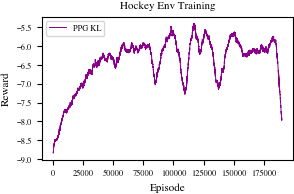

In [54]:
# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 5000

plt.rcParams.update(bundles.icml2022(column = "full", nrows = 1, ncols = 1, usetex = False))
fig, ax = plt.subplots(figsize = (3, 2))
plt.plot(moving_average(rewards_ppg_kl, wind_size), linewidth = 0.7, label = "PPG KL", color = "darkmagenta")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Hockey Env Training")
plt.legend()
# plt.grid()
plt.show()

# save figure as png
fig.savefig("../doc/fig/rewards_final_model.png", dpi = 1000, bbox_inches = "tight", pad_inches = 0.1, transparent = True)

## Evaluation

Testing the final agent on the hockey environment. We are paying 500 games against the weak and strong basic opponentseparately.

In [20]:
def test_agent(number_games, weak_mode, agent):
    winner_list = np.zeros(number_games)
    rewards = 0
    env = h_env.HockeyEnv(mode = Mode.NORMAL)
    memory = None

    for i in range(number_games):

        state, _ = env.reset()
        state = state.flatten()
        player2 = h_env.BasicOpponent(weak = weak_mode)
        obs_agent2 = env.obs_agent_two()

        for t in range(500):

            action = agent.policy_old.act(state, memory)

            action_opp = player2.act(obs_agent2)

            next_state, reward, done, _, info = env.step(np.hstack([action, action_opp]))
            next_state = next_state.flatten()

            state = next_state

            obs_agent2 = env.obs_agent_two()

            rewards += reward
            if done:
                winner_list[i] = info["winner"]
                break

    print("Winning rate: ", np.round(np.sum(winner_list == 1) / number_games, 3))
    print("Draws rate: ", np.round(np.sum(winner_list == 0) / number_games, 3))
    print("Losing rate: ", np.round(np.sum(winner_list == -1) / number_games, 3))
    print("Avg. reward: ", np.round(rewards / number_games))
    return winner_list

In [60]:
# load checkpoint
from src.PPG_KL import PPO
ppg_KL = PPO(
    18,
    4,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 2,
    network_depth_critic = 2,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.0003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

ppg_KL.load_checkpoint("../dat/ppg_kl/checkpoint_120000.pth")

Loaded checkpoint from ../dat/ppg_kl/checkpoint_120000.pth


In [47]:
# load checkpoint
from PPO import PPO
ppo = PPO(
    18,
    4,
    n_latent_var = 128,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.0003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25
)

ppo.load_checkpoint("../dat/ppo/checkpoint_163000.pth")

Loaded checkpoint from ../dat/ppo/checkpoint_163000.pth


In [61]:
# Test agent
number_games = 500
weak_mode = True

print("Weak Opponent")
winner_weak = test_agent(number_games, weak_mode, ppo)

weak_mode = False
print("\nStrong Opponent")
winner_strong = test_agent(number_games, weak_mode, ppo)

Weak Opponent
Winning rate:  0.338
Draws rate:  0.386
Losing rate:  0.276
Avg. reward:  -3.0

Strong Opponent
Winning rate:  0.276
Draws rate:  0.344
Losing rate:  0.38
Avg. reward:  -6.0


Win rate weak opponent: 0.338, Win rate strong opponent: 0.276


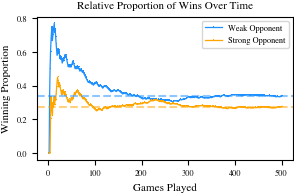

In [62]:
# plot win rate
num_episodes = len(winner_weak)

num_wins_weak = np.sum(np.array(winner_weak) == 1)
num_wins_strong = np.sum(np.array(winner_strong) == 1)

ratio_wins_weak = round(num_wins_weak / num_episodes, 3)
ratio_wins_strong = round(num_wins_strong / num_episodes, 3)

print(f"Win rate weak opponent: {ratio_wins_weak}, Win rate strong opponent: {ratio_wins_strong}")

info_array_weak = np.array(winner_weak)
info_array_strong = np.array(winner_strong)

games_played = np.arange(1, len(winner_weak) + 1)
wins_weak = np.cumsum(info_array_weak == 1)
wins_strong = np.cumsum(info_array_strong == 1)

win_ratio_weak = wins_weak / games_played
win_ratio_strong = wins_strong / games_played

plt.rcParams.update(bundles.icml2022(column = "full", nrows = 1, ncols = 1, usetex = False))
fig, ax = plt.subplots(figsize = (3, 2))
plt.plot(games_played, win_ratio_weak, marker = ',', linestyle = '-', label = "Weak Opponent", linewidth = 0.9, color = "dodgerblue")
plt.plot(games_played, win_ratio_strong, marker = ',', linestyle = '-', label = "Strong Opponent", linewidth = 0.9, color = "orange")
plt.axhline(y = ratio_wins_weak, linestyle = '--', color = "dodgerblue", alpha = 0.5)
plt.axhline(y = ratio_wins_strong, linestyle = '--', color = "orange", alpha = 0.5)
plt.xlabel("Games Played")
plt.ylabel("Winning Proportion")
plt.title("Relative Proportion of Wins Over Time")
plt.legend()
# plt.grid(True)
plt.show()

# save figure as png
fig.savefig("../doc/fig/winningrate_final_model.png", dpi = 1000, bbox_inches = "tight", pad_inches = 0.1, transparent = True)